In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit,minimize
from HOTRG import get_lattice_size,get_dist_torus_2D,get_dist_2D
import matplotlib as mpl
import importlib
import correlation_ansatzs
importlib.reload(correlation_ansatzs)
from correlation_ansatzs import high_temp_correlation,low_temp_correlation,low_temp_correlation_1,low_temp_correlation_2,critical_correlation,loglog

%matplotlib inline

def process_data(data,log2Size=30):
    lattice_size=get_lattice_size(nLayers=2*log2Size,spacial_dim=2)
    data['x']=data.apply(lambda row:row['x1']-row['x0'],axis=1)
    data['y']=data.apply(lambda row:row['y1']-row['y0'],axis=1)
    data['dist']=data.apply(lambda row:get_dist_torus_2D(row['x'],row['y'],lattice_size),axis=1)
    data['theta']=data.apply(lambda row:np.arctan2(row['y'],row['x']),axis=1)
    data=data.sort_values(by=['dist'])
    return data

def fitWithHuberLoss(ansatz,x,y,p0=None,epsilon=1,
                             allow_positive_outliers=True,allow_negative_outliers=True):
    def loss(xs,ys,*p):
        dist=ys-ansatz(xs,*p)
        loss1=1/2 * dist**2 # lsq
        loss2=epsilon*(np.abs(dist)-epsilon/2) # huber
        if allow_positive_outliers:
            loss1[dist>epsilon]=loss2[dist>epsilon]
        if allow_negative_outliers:
            loss1[dist<-epsilon]=loss2[dist<-epsilon]
        return np.sum(loss1)
    xfit,yfit=x,y
    res=minimize(lambda p: loss(xfit,yfit,*p),p0,method='Nelder-Mead',tol=1e-6)
    p=res.x
    return p


def fit_data(data,ansatz):
    data_slice=data[(data['correlation']>1e-2)].sort_values('dist')
    logx,logy=np.log(data_slice['dist']),np.log(data_slice['correlation'])
    p,cov=curve_fit(loglog(ansatz),logx,logy,p0=ansatz.p0,maxfev=10000)
    p=fitWithHuberLoss(loglog(ansatz),logx,logy,p0=p,epsilon=0.1)
    cov=None
    print('fitted parameters:',p)
    print('fitted equation:',ansatz.eq.format(*p))
    return p,cov,ansatz

# correlation below, above and at the critical point

critical temperature
fitted parameters: [0.67689318 0.1280528 ]
fitted equation: 6.77e-01x^(-2 Δ),Δ=0.1281
high temperature
fitted parameters: [6.80194041e-01 1.99208819e+04 1.32271406e-01]
fitted equation: 6.80e-01e^(-x/ζ)/x^(2 Δ),ζ=1.99e+04,Δ=0.1323
low temperature
fitted parameters: [6.30430839e-01 2.67964854e+03 1.17719932e-01 5.48931238e-01]
fitted equation: 6.30e-01(ζ^(-1/B)+x^(-1/B))^(2 ∆ B),ζ=2.68e+03,∆=0.1177,B=0.5
with GILT


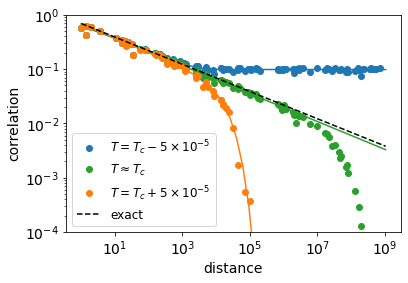

In [3]:

data1=pd.read_pickle('data/hotrg_gilt_X24_correlation.pkl')
data1=process_data(data1,log2Size=30)
print('critical temperature')
p1,cov1,ansatz1=fit_data(data1,critical_correlation)
data2=pd.read_pickle('data/hotrg_gilt_X24_lowB_correlation.pkl')
data2=process_data(data2,log2Size=30)
print('high temperature')
p2,cov2,ansatz2=fit_data(data2,high_temp_correlation)
data3=pd.read_pickle('data/hotrg_gilt_X24_highB_correlation.pkl')
data3=process_data(data3,log2Size=30)
print('low temperature')
p3,cov3,ansatz3=fit_data(data3,low_temp_correlation_2)
pexp=(0.69,0.125)

print('with GILT')

ls=np.geomspace(1,2**30)

plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 14,'legend.fontsize':12})
plt.plot(ls,ansatz3(ls,*p3),'-',color='tab:blue')
plt.plot(ls,ansatz1(ls,*p1),'-',color='tab:green')
plt.plot(ls,ansatz2(ls,*p2),'-',color='tab:orange')
plt.plot(data3['dist'],data3['correlation'],'o',label=r'$T=T_c-5\times10^{-5}$',color='tab:blue')
plt.plot(data1['dist'],data1['correlation'],'o',label=r'$T \approx T_c$',color='tab:green')
plt.plot(data2['dist'],data2['correlation'],'o',label=r'$T=T_c+5\times10^{-5}$',color='tab:orange')
plt.plot(ls,ansatz1(ls,*pexp),'--',color='black',label='exact')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('distance')
plt.ylabel('correlation')
plt.ylim([1e-4,1])
plt.legend()
plt.show()



# comparison of different methods

- w and w/o gilt
- fix x0y0 or not

with GILT
fitted parameters: [0.67689318 0.1280528 ]
fitted equation: 6.77e-01x^(-2 Δ),Δ=0.1281
without GILT
fitted parameters: [0.69707343 0.12887387]
fitted equation: 6.97e-01x^(-2 Δ),Δ=0.1289
with GILT, 00
fitted parameters: [0.68716384 0.23396986]
fitted equation: 6.87e-01x^(-2 Δ),Δ=0.2340
without GILT, 00
fitted parameters: [0.70295341 0.11281545]
fitted equation: 7.03e-01x^(-2 Δ),Δ=0.1128


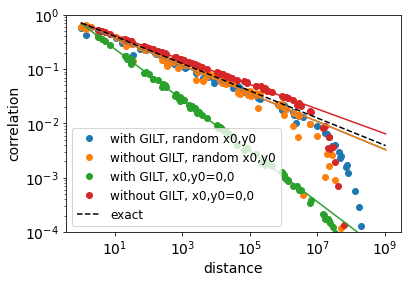

In [4]:
data1=pd.read_pickle('data/hotrg_gilt_X24_correlation.pkl')
data2=pd.read_pickle('data/hotrg_X24_correlation.pkl')
data3=pd.read_pickle('data/hotrg_gilt_X24_correlation_00.pkl')
data4=pd.read_pickle('data/hotrg_X24_correlation_00.pkl')


data1=process_data(data1,log2Size=30)
data2=process_data(data2,log2Size=30)
data3=process_data(data3,log2Size=30)
data4=process_data(data4,log2Size=30)


print('with GILT')
p1,cov1,ansatz1=fit_data(data1,critical_correlation)

print('without GILT')
p2,cov2,ansatz2=fit_data(data2,critical_correlation)

print('with GILT, 00')
p3,cov3,ansatz3=fit_data(data3,critical_correlation)

print('without GILT, 00')
p4,cov4,ansatz4=fit_data(data4,critical_correlation)

pexp=(0.71,0.125)

plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 14,'legend.fontsize':12})

ls=np.geomspace(1,2**30)

plt.plot(data1['dist'],data1['correlation'],'o',label='with GILT, random x0,y0',color='C0')
plt.plot(data2['dist'],data2['correlation'],'o',label='without GILT, random x0,y0',color='C1')
plt.plot(data3['dist'],data3['correlation'],'o',label='with GILT, x0,y0=0,0',color='C2')
plt.plot(data4['dist'],data4['correlation'],'o',label='without GILT, x0,y0=0,0',color='C3')

plt.plot(ls,ansatz1(ls,*p1),'-',color='C0')
plt.plot(ls,ansatz2(ls,*p2),'-',color='C1')
plt.plot(ls,ansatz3(ls,*p3),'-',color='C2')
plt.plot(ls,ansatz4(ls,*p4),'-',color='C3')
plt.plot(ls,ansatz4(ls,*pexp),'--',color='black',label='exact')



plt.xscale('log')
plt.yscale('log')
plt.xlabel('distance')
plt.ylabel('correlation')
plt.ylim([1e-4,1])
plt.legend()
plt.show()


# Comparison of two low temp ansatzs

low temperature
fitted parameters: [6.09086611e-01 1.70737530e+03 1.70813537e-01 3.13860692e-01]
fitted equation: 6.09e-01e^(-x/ζ)/x^(2 Δ)+m0^2,ζ=1.71e+03,Δ=0.1708,m0=0.314
fitted parameters: [6.79377057e-01 2.45102382e+03 1.23910350e-01 7.02862086e-01]
fitted equation: 6.79e-01(ζ^(-1/B)+x^(-1/B))^(2 ∆ B),ζ=2.45e+03,∆=0.1239,B=0.7


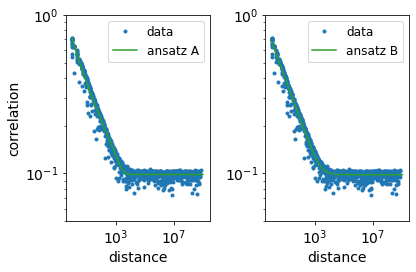

In [5]:
# compare low_temp_correlation and low_temp_correlation_1
importlib.reload(correlation_ansatzs)
from correlation_ansatzs import low_temp_correlation,low_temp_correlation_1,low_temp_correlation_2,low_temp_correlation_3


data1=pd.read_pickle('data/hotrg_gilt_X24_highB_correlation.pkl') # low temperature
data1=pd.concat([data1,pd.read_pickle('data/hotrg_gilt_X24_highB_correlation_appended.pkl')])
data1=process_data(data1,log2Size=30)
print('low temperature')
p1,cov1,ansatz1=fit_data(data1,low_temp_correlation)
p2,cov2,ansatz2=fit_data(data1,low_temp_correlation_2)

ls=np.geomspace(1,2**30)

plt.figure(figsize=(6,4))
plt.rcParams.update({'font.size': 14,'legend.fontsize':12})
plt.subplot(1,2,1)
plt.plot(data1['dist'],data1['correlation'],'.',label=r'data',color='tab:blue')
plt.plot(ls,ansatz1(ls,*p1),'-',color='tab:green',label='ansatz A')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('distance')
plt.ylabel('correlation')
plt.ylim([5e-2,1])
plt.legend()
plt.subplot(1,2,2)
plt.plot(data1['dist'],data1['correlation'],'.',label=r'data',color='tab:blue')
plt.plot(ls,ansatz2(ls,*p2),'-',color='tab:green',label='ansatz B')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('distance')
plt.ylim([5e-2,1])
plt.legend()
plt.tight_layout()


plt.show()


# four point function

In [9]:
import importlib
import correlation_ansatzs
importlib.reload(correlation_ansatzs)

from correlation_ansatzs import ising_four_sigma_correlation,loglog
from scipy.optimize import curve_fit

data=pd.read_pickle('data/hotrg_gilt_X24_4pt_correlation_10.pkl')
def process_data(data):
    lattice_size=get_lattice_size(20,spacial_dim=2)
    for i in range(4):
        for j in range(i+1,4):
            data['dist{}{}'.format(i,j)]=data.apply(lambda row:get_dist_2D(row['x{}'.format(i)]-row['x{}'.format(j)],row['y{}'.format(i)]-row['y{}'.format(j)]),axis=1)
    dists=[data['dist{}{}'.format(i,j)].to_numpy() for i in range(4) for j in range(i+1,4)]
    data['expected']=ising_four_sigma_correlation(dists,Anorm=1,deltaSigma=0.125,deltaEpsilon=1,CdeltadeltaEpsilon=.5)
    return data
data=process_data(data)



# fit the data 
dists=[data['dist{}{}'.format(i,j)].to_numpy() for i in range(4) for j in range(i+1,4)]
corr=data['correlation'].to_numpy()
logDists=[np.log(dists[i]) for i in range(6)]
logCorr=np.log(corr)
print('start fitting')
# loglog scale
p,cov=curve_fit(loglog(ising_four_sigma_correlation),logDists,logCorr,
                p0=ising_four_sigma_correlation.p0,bounds=ising_four_sigma_correlation.bounds)
# linear scale
# p,cov=curve_fit(ising_four_sigma_correlation,dists,corr,
#                p0=ising_four_sigma_correlation.p0,bounds=ising_four_sigma_correlation.bounds)
print('fitted parameters:',p)
print('covariance matrix:',cov)
print('fitted equation:',ising_four_sigma_correlation.eq.format(*p))

print('refining fitting with Huber loss')
p=fitWithHuberLoss(loglog(ising_four_sigma_correlation),logDists,logCorr,p0=p,epsilon=.1)
cov=None
print('fitted parameters:',p)
print('fitted equation:',ising_four_sigma_correlation.eq.format(*p))





start fitting
fitted parameters: [0.61567983 0.17613768 1.50171748 0.37264522]
covariance matrix: [[ 5.63603655e-04  5.38283820e-05  1.93313855e-04 -1.40416637e-05]
 [ 5.38283820e-05  6.11459699e-06 -2.15486374e-05  1.56242166e-05]
 [ 1.93313855e-04 -2.15486374e-05  5.95674426e-03 -1.46453902e-03]
 [-1.40416637e-05  1.56242166e-05 -1.46453902e-03  4.65702261e-04]]
fitted equation: A=6.16e-01,Δσ=0.1761,Δε=1.5017,C(σσε)=0.3726
refining fitting with Huber loss
fitted parameters: [0.2062048  0.11010378 1.07591539 0.43871535]
fitted equation: A=2.06e-01,Δσ=0.1101,Δε=1.0759,C(σσε)=0.4387


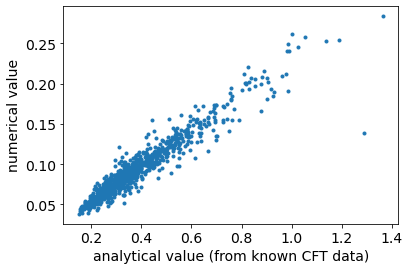

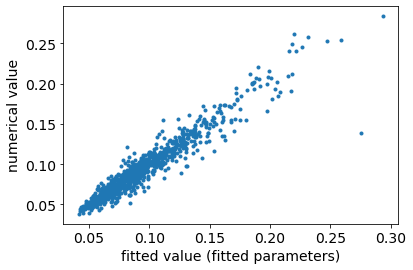

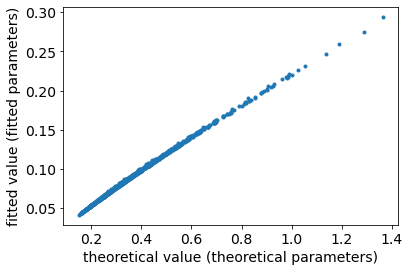

In [10]:
plt.rcParams.update({'font.size': 14,'legend.fontsize':12})
plt.figure(figsize=(6,4))
plt.plot(data['expected'],data['correlation'],'.')
plt.xlabel('analytical value (from known CFT data)')
plt.ylabel('numerical value')
plt.show()


fitted_expected=ising_four_sigma_correlation(dists,*p)
plt.figure(figsize=(6,4))
plt.plot(fitted_expected,data['correlation'],'.')
plt.xlabel('fitted value (fitted parameters)')
plt.ylabel('numerical value')
plt.show()


plt.figure(figsize=(6,4))
plt.plot(data['expected'],fitted_expected,'.')
plt.xlabel('theoretical value (theoretical parameters)')
plt.ylabel('fitted value (fitted parameters)')
plt.show()